In [101]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
import numpy as np
import os,random, math
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False
plt.rc('font', size=15)

# from dataprep.eda import plot, plot_correlation, plot_missing

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error 

from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score

In [102]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.dirname(path)
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [103]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

상가비율

In [104]:
tmp = train.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
train = pd.merge(train,total[['단지코드','상가비율']],on='단지코드',how='left')

In [105]:
tmp = test.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
test = pd.merge(test,total[['단지코드','상가비율']],on='단지코드',how='left')

In [106]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

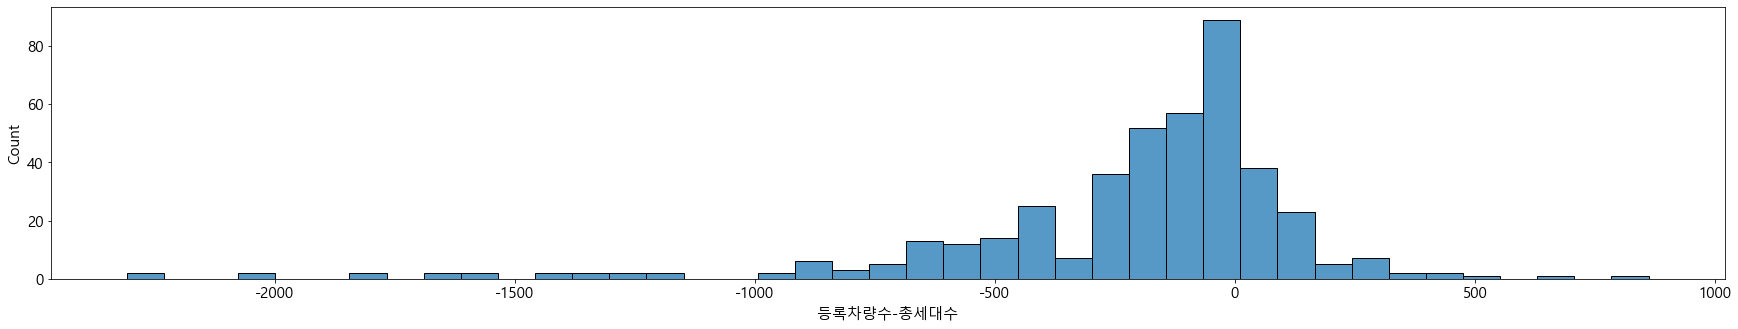

In [107]:
tmp = train[train['단지내주차면수']<987][['등록차량수','단지코드','지역','공급유형','총세대수','단지내주차면수']].drop_duplicates()
tmp['등록차량수-총세대수'] = tmp.apply(lambda x : x['등록차량수']-x['총세대수'],axis=1)
fig, ax = plt.subplots(figsize=(30,5))
sns.histplot(data=tmp,x='등록차량수-총세대수')

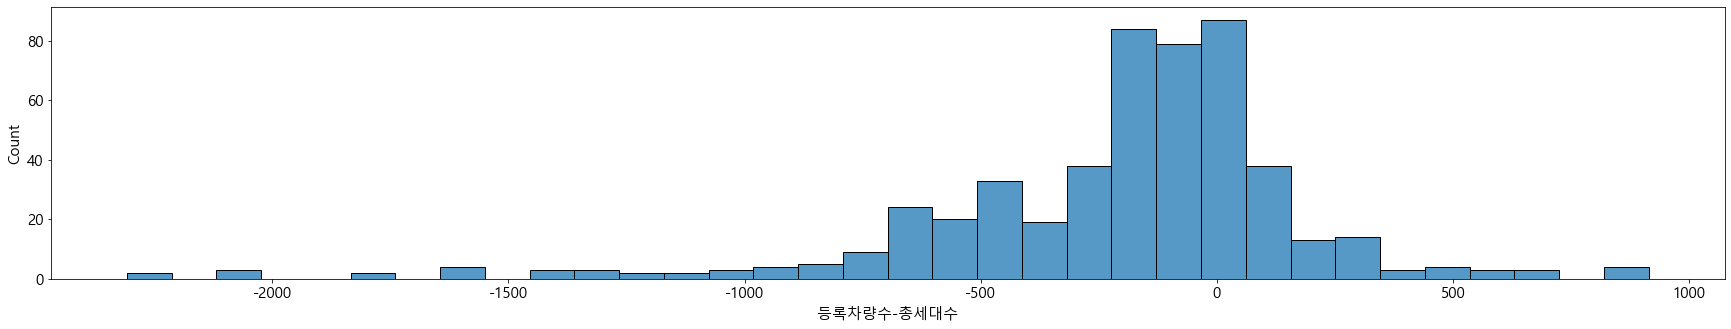

In [108]:
tmp = train.copy()
tmp = tmp[['등록차량수','단지코드','지역','공급유형','총세대수','단지내주차면수','자격유형']].drop_duplicates()
tmp['등록차량수-총세대수'] = tmp.apply(lambda x : x['등록차량수']-x['총세대수'],axis=1)

fig, ax = plt.subplots(figsize=(30,5))
sns.histplot(data=tmp,x='등록차량수-총세대수')

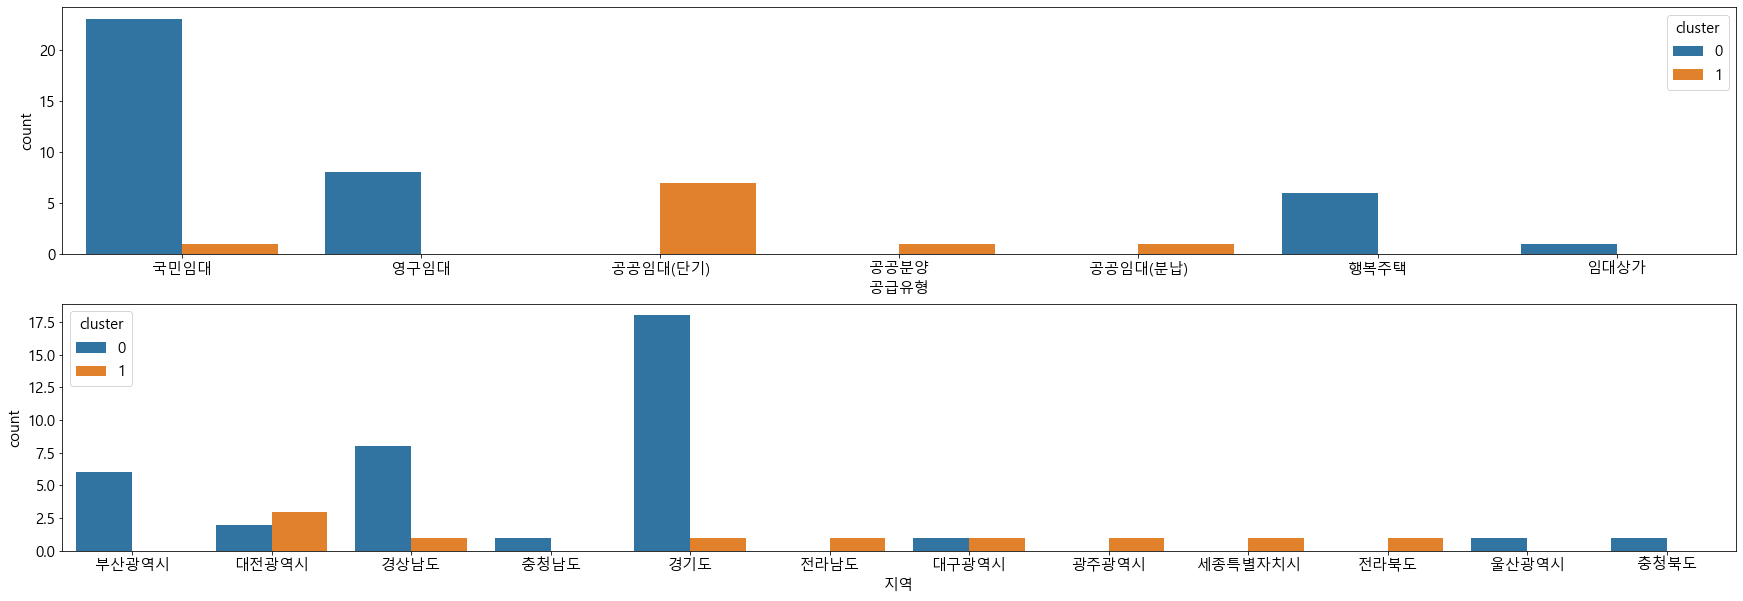

In [109]:
tmp = train.copy()
tmp = tmp[['등록차량수','단지코드','지역','공급유형','총세대수','단지내주차면수','자격유형']].drop_duplicates()
tmp['등록차량수-총세대수'] = tmp.apply(lambda x : x['등록차량수']-x['총세대수'],axis=1)
tmp = tmp[(tmp['등록차량수-총세대수']>500)|(tmp['등록차량수-총세대수']<-500)]
tmp = tmp[tmp['단지내주차면수']>=600]
tmp['cluster'] = tmp.apply(lambda x : 1 if x['등록차량수-총세대수']>0 else 0 ,axis=1)

fig, ax = plt.subplots(2,1,figsize=(30,10))
sns.countplot(data=tmp,x='공급유형',hue='cluster',ax=ax[0])
sns.countplot(data=tmp,x='지역',hue='cluster',ax=ax[1])

- 국민임대, 영구임대, 행복주택, 임대상가
- 공공임대(단기) 공공분양 공공임대(분납)

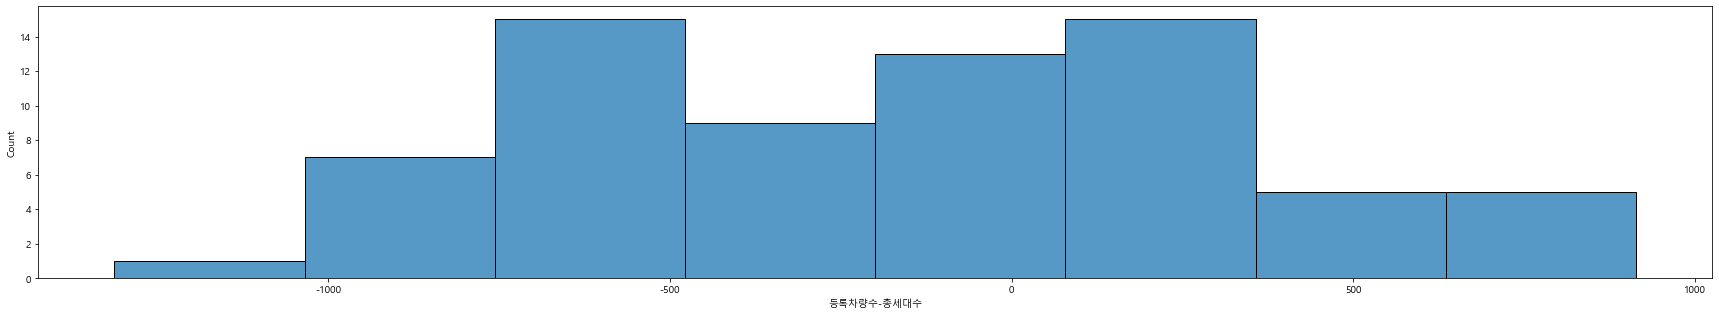

In [92]:
tmp = train[train['단지내주차면수']>=987][['등록차량수','단지코드','지역','공급유형','총세대수','단지내주차면수','자격유형']].drop_duplicates()
tmp['등록차량수-총세대수'] = tmp.apply(lambda x : x['등록차량수']-x['총세대수'],axis=1)

fig, ax = plt.subplots(figsize=(30,5))
sns.histplot(data=tmp,x='등록차량수-총세대수')

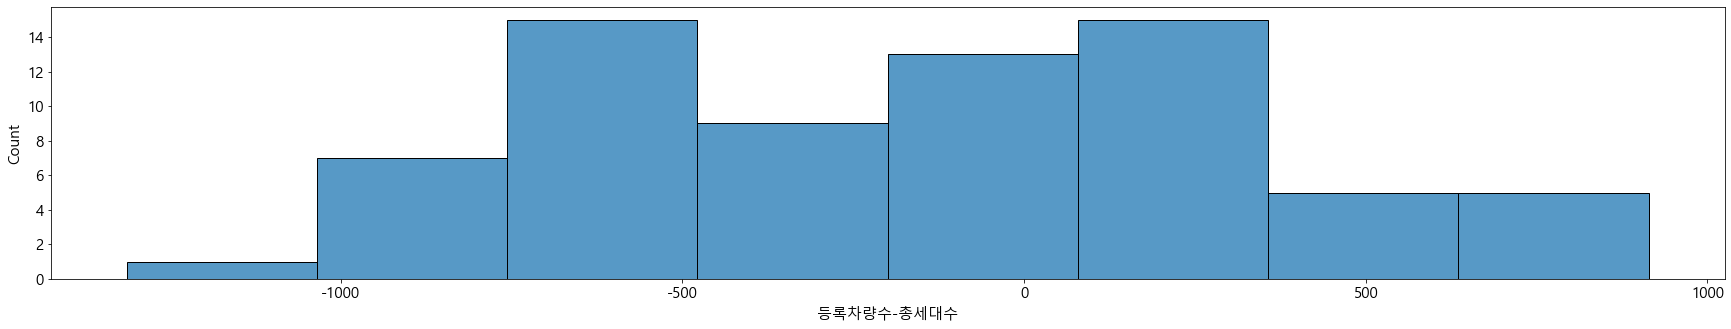

In [8]:
tmp = train[train['단지내주차면수']>=987][['등록차량수','단지코드','지역','공급유형','총세대수','단지내주차면수','자격유형']].drop_duplicates()
tmp['등록차량수-총세대수'] = tmp.apply(lambda x : x['등록차량수']-x['총세대수'],axis=1)
tmp['cluster'] = tmp.apply(lambda x : 1 if x['등록차량수-총세대수']>0 else 0 ,axis=1)

fig, ax = plt.subplots(figsize=(30,5))
sns.histplot(data=tmp,x='등록차량수-총세대수')

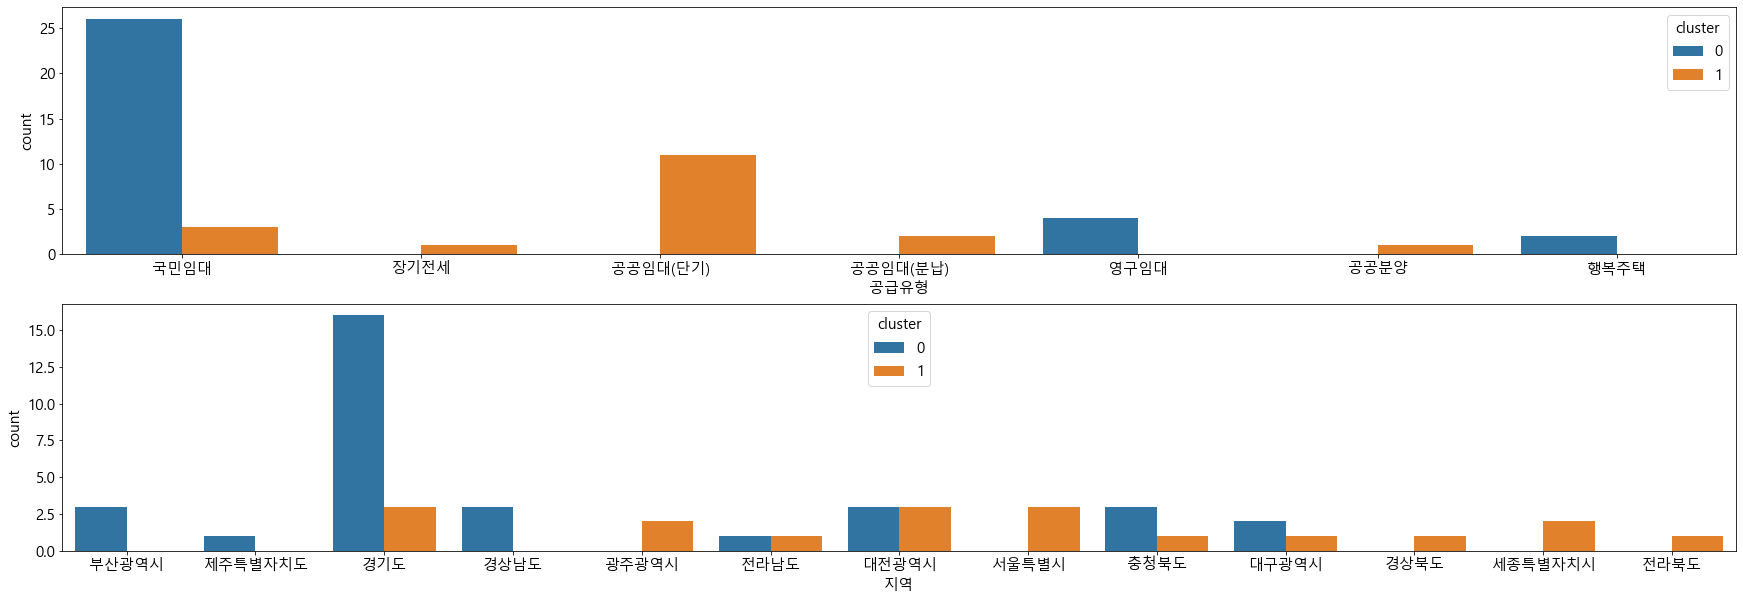

In [9]:
tmp = tmp[(tmp['등록차량수-총세대수']>200)|(tmp['등록차량수-총세대수']<-200)]
fig, ax = plt.subplots(2,1,figsize=(30,10))
sns.countplot(data=tmp,x='공급유형',hue='cluster',ax=ax[0])
sns.countplot(data=tmp,x='지역',hue='cluster',ax=ax[1])

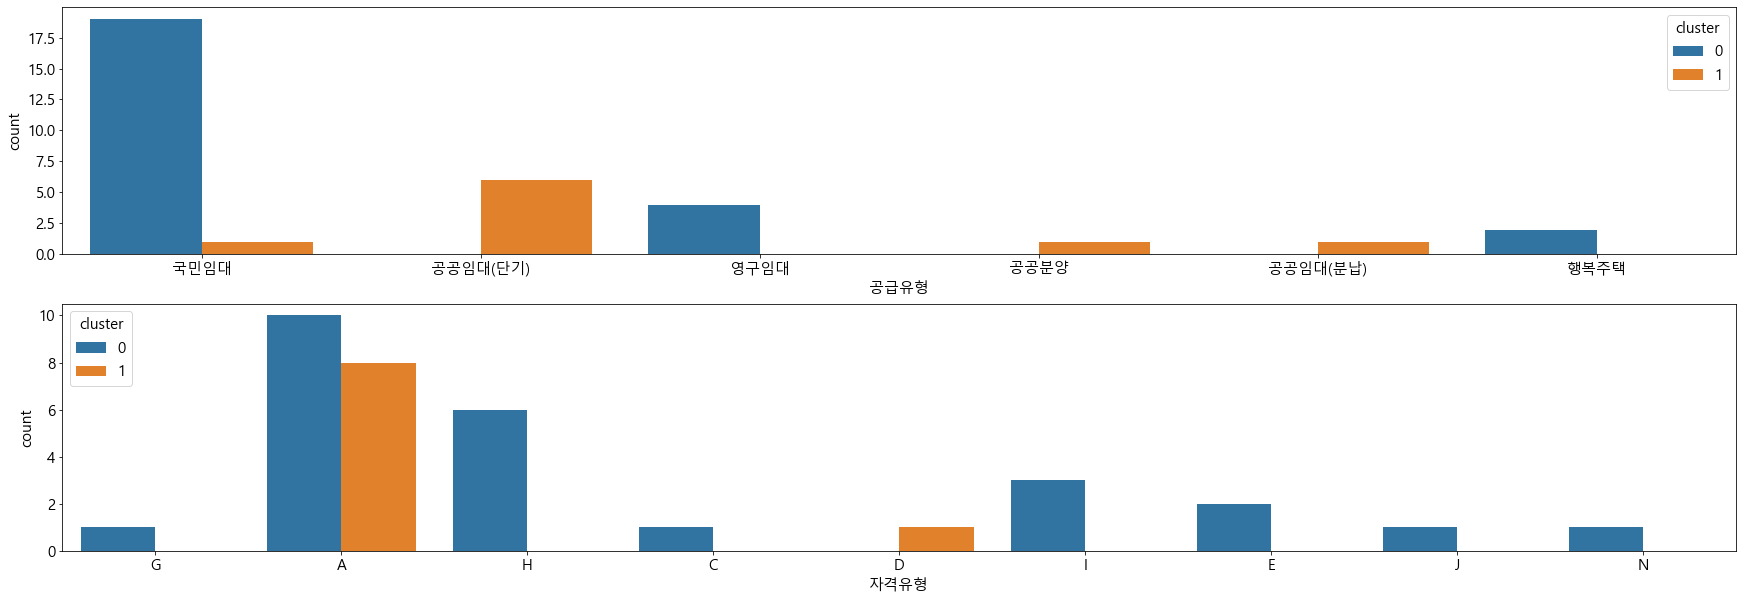

In [10]:
tmp1 = tmp.loc[tmp['지역'].isin(['경기도','전라남도','대전광역시','충청북도','대구광역시']),:]
fig, ax = plt.subplots(2,1,figsize=(30,10))
sns.countplot(data=tmp1,x='공급유형',hue='cluster',ax=ax[0])
sns.countplot(data=tmp1,x='자격유형',hue='cluster',ax=ax[1])

- 부산광역시, 제주특별자치도, 경상남도, 강원도 : 등록차량수 < 총세대수
- 광주광역시, 서울특별시, 경상북도, 세종특별자치시, 전라북도 : 등록차량수 > 총세대수
- 경기도, 경상남도, 전라남도, 대전광역시, 충청북도, 대구광역시 & 영구임대, 행복주택, 국민임대 : 등록차량수 < 총세대수
- 경기도, 경상남도, 전라남도, 대전광역시, 충청북도, 대구광역시 & 공공임대(단기) 공공분양 공공임대(분납): 등록차량수 > 총세대수

In [11]:
# train.loc[(train['단지내주차면수']>=987)&(train['지역'].isin(['제주특별자치도','경상남도','부산광역시','강원도'])),'지역'] = 0
# train.loc[(train['단지내주차면수']>=987)&(train['지역'].isin(['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시'])),'지역'] = 1
# train.loc[(train['단지내주차면수']>=987)&(train['지역'].isin(['경기도','경상남도','전라남도','대전광역시','충청북도','대구광역시']))&(train['공급유형'].isin(['영구임대','행복주택','국민임대'])),'지역'] = 2
# train.loc[(train['단지내주차면수']>=987)&(train['지역'].isin(['경기도','경상남도','전라남도','대전광역시','충청북도','대구광역시']))&(train['공급유형'].isin(['공공임대(단기)','공공분양','공공임대(분납)'])),'지역'] = 3

In [12]:
# test.loc[(test['단지내주차면수']>=987)&(test['지역'].isin(['제주특별자치도','경상남도','부산광역시','강원도'])),'지역'] = 0
# test.loc[(test['단지내주차면수']>=987)&(test['지역'].isin(['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시'])),'지역'] = 1
# test.loc[(test['단지내주차면수']>=987)&(test['지역'].isin(['경기도','경상남도','전라남도','대전광역시','충청북도','대구광역시']))&(test['공급유형'].isin(['영구임대','행복주택','국민임대'])),'지역'] = 2
# test.loc[(test['단지내주차면수']>=987)&(test['지역'].isin(['경기도','경상남도','전라남도','대전광역시','충청북도','대구광역시']))&(test['공급유형'].isin(['공공임대(단기)','공공분양','공공임대(분납)'])),'지역'] = 3

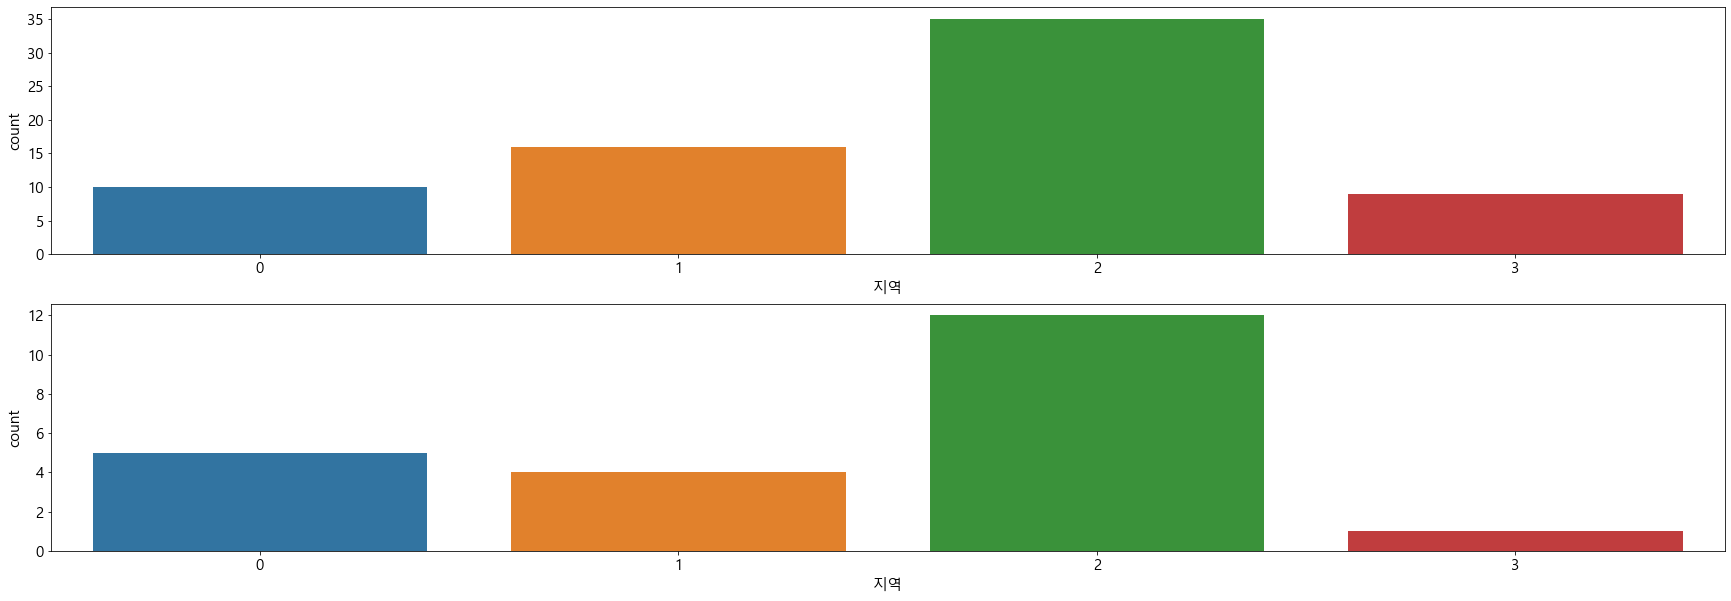

In [13]:
tmp = train[train['단지내주차면수']>=987][['등록차량수','단지코드','지역','공급유형','총세대수','단지내주차면수','자격유형']].drop_duplicates()
tmp1 = test[test['단지내주차면수']>=987][['단지코드','지역','공급유형','총세대수','단지내주차면수','자격유형']].drop_duplicates()
fig, ax = plt.subplots(2,1,figsize=(30,10))
sns.countplot(data=tmp,x='지역',ax=ax[0])
sns.countplot(data=tmp1,x='지역',ax=ax[1])

세대당가능주차면수

In [14]:
train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

In [15]:
train['공가비율'] = train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['공가비율'] = test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)

In [16]:
level = 85
train['대형전용면적'] = train['전용면적'].apply(lambda x : 1 if x>level else 0)
test['대형전용면적'] = test['전용면적'].apply(lambda x : 1 if x>level else 0)

In [17]:
train['대형전용면적'] = train['전용면적'].apply(lambda x : 1 if x>level else 0)
test['대형전용면적'] = test['전용면적'].apply(lambda x : 1 if x>level else 0)

In [18]:
not_unique = ['공급유형','전용면적','임대건물구분','전용면적별세대수','대형전용면적','임대보증금','임대료','자격유형']

train_one = train.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)
test_one = test.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)

In [19]:
for i in train['공급유형'].unique():
    train_one[i] = 0
    test_one[i] = 0

In [20]:
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = train_one[train_one['단지코드']==code].index
    train_one.loc[ind,col] = val

In [21]:
sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = test_one[test_one['단지코드']==code].index
    test_one.loc[ind,col] = val

In [22]:
sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

In [23]:
sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

In [24]:
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
train_one = pd.merge(train_one, sample, on="단지코드", how="left")

In [25]:
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
test_one = pd.merge(test_one, sample, on="단지코드", how="left")

In [26]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2) # 12345 중에 2가 제일 좋음

sample = train.groupby('단지코드').mean()[['전용면적']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

sample = test.groupby('단지코드').mean()[['전용면적']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

train_one["연면적new"]=train_one.연면적
test_one["연면적new"]=test_one.연면적

train_one.loc[(train_one.연면적new<train_one.전용면적), "연면적new"]=np.nan
test_one.loc[(test_one.연면적new<test_one.전용면적), "연면적new"]=np.nan

im=train_one[["단지내주차면수", "총세대수", "전용면적", "연면적new"]]
im = pd.DataFrame(imputer.fit_transform(im),
                     columns = im.columns)

train_one["연면적new"]=im["연면적new"]

imp=test_one[["단지내주차면수", "총세대수", "전용면적", "연면적new"]]
imp = pd.DataFrame(imputer.fit_transform(imp),
                     columns = imp.columns)

test_one["연면적new"]=imp["연면적new"]

In [27]:
col = ['단지명','도로명주소','subway_name','임대상가']

train_one = train_one.drop(col,axis=1)
test_one = test_one.drop(col,axis=1)

In [28]:
train_up = train_one[train_one['단지내주차면수']>=987].reset_index(drop=True)
train_down = train_one[train_one['단지내주차면수']<987].reset_index(drop=True)

In [29]:
test_up = test_one[test_one['단지내주차면수']>=987].reset_index(drop=True)
test_down = test_one[test_one['단지내주차면수']<987].reset_index(drop=True)

In [30]:
# train_up['지역'] = train_up['지역'].apply(lambda x :str(x))
# test_up['지역'] = test_up['지역'].apply(lambda x :str(x))

In [31]:
train_up = train_up.join(pd.get_dummies(train_up['지역'],prefix='area')).iloc[:,:-1]
test_up = test_up.join(pd.get_dummies(test_up['지역'],prefix='area')).iloc[:,:-1]

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor 
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as LGB
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR

In [33]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            print(f"model:{str(m).split('(')[0]}\nMAE:{cv_error}")
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
    best_tst_pred = sum(best_tst_pred,[])
    best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    return best_model, best_tst_pred, best_error

In [34]:
X = train_down.drop(columns=['단지코드','등록차량수'],axis=1)
X = pd.get_dummies(X, drop_first=True) 
X['지역_세종특별자치시'] = 0
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', '지역_경기도', '지역_경상남도', '지역_경상북도', '지역_광주광역시',
       '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시', '지역_세종특별자치시',
       '지역_울산광역시', '지역_전라남도', '지역_전라북도', '지역_제주특별자치도', '지역_충청남도', '지역_충청북도']]
y = train_down['등록차량수']

In [35]:
models = [CatBoostRegressor(random_state=2021)]
model_down,pred_down,error_down = fit_models(X, y, models, cv=True)
print('MAE : ',error_down)

model:<catboost.core.CatBoostRegressor object at 0x000002AA7F604D60>
MAE:105.69855840723085
MAE :  105.69855840723085


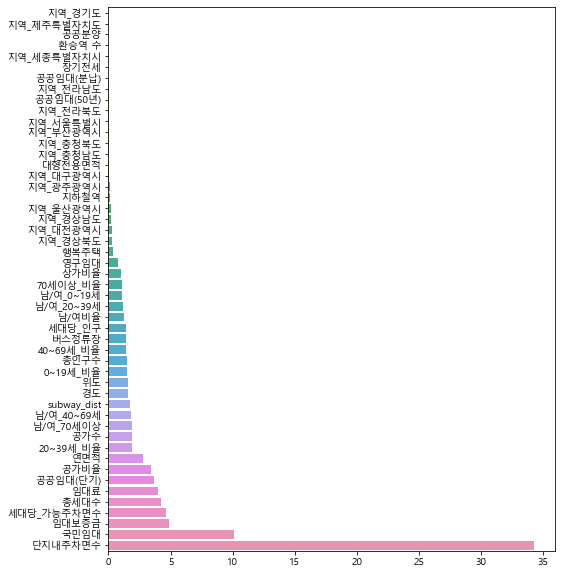

In [36]:
plt.rc('font', size=10)
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(model_down.feature_importances_)], x = list(model_down.feature_importances_[np.argsort(model_down.feature_importances_)]))

In [37]:
X = train_up.drop(columns=['단지코드','등록차량수'],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적','area_0','area_1','area_2']]
y = train_up['등록차량수']

In [38]:
model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
print('MAE : ',error_up)

model:<catboost.core.CatBoostRegressor object at 0x000002AA7F604D60>
MAE:290.0545809808965
MAE :  290.0545809808965


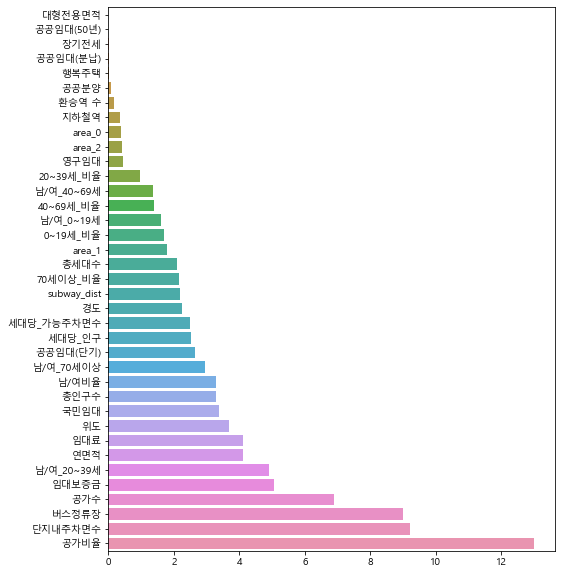

In [40]:
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(model_up.feature_importances_)], x = list(model_up.feature_importances_[np.argsort(model_up.feature_importances_)]))

In [39]:
(error_down*train_down.shape[0]+error_up*train_up.shape[0])/(train_down.shape[0]+train_up.shape[0])

128.85438732952701

In [41]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', '지역_경기도', '지역_경상남도', '지역_경상북도', '지역_광주광역시',
       '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시', '지역_세종특별자치시',
       '지역_울산광역시', '지역_전라남도', '지역_전라북도', '지역_제주특별자치도', '지역_충청남도', '지역_충청북도']

In [42]:
X_train = train_down.drop(columns=['단지코드','등록차량수'],axis=1)
X_train = pd.get_dummies(X_train, drop_first=True) 
X_train['지역_세종특별자치시'] = 0
X_train = X_train[col]
y_train = train_down['등록차량수']
X_test = test_down.drop(columns=['단지코드'],axis=1)
X_test = pd.get_dummies(X_test, drop_first=True) 
X_test['지역_서울특별시'] = 0
X_test = X_test[col]

In [43]:
cb_down = CatBoostRegressor(random_state=2021,verbose=False).fit(X_train,y_train)
pred_down = cb_down.predict(X_test)

In [47]:
col = ['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수', '연면적', '위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적','area_0','area_1','area_2']
# train_up['지역'] = train_up['지역'].apply(lambda x :str(x))
# test_up['지역'] = test_up['지역'].apply(lambda x :str(x))

In [48]:
X_train = train_up.drop(columns=['단지코드','등록차량수'],axis=1)
X_train = X_train[col]
y_train = train_up['등록차량수']
X_test = test_up.drop(columns=['단지코드'],axis=1)
X_test = X_test[col]

cb_up = CatBoostRegressor(random_state=2021,verbose=False,loss_function='MAE').fit(X_train,y_train)
#cb_up = ElasticNet(random_state=2021).fit(X_train,y_train)
pred_up = cb_up.predict(X_test)

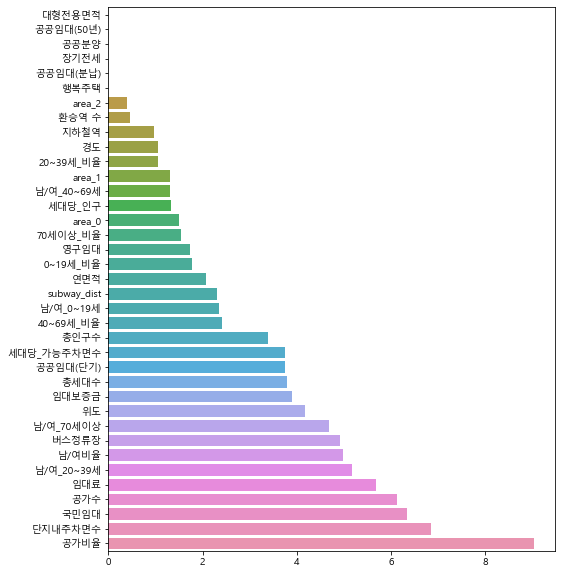

In [50]:
plt.rc('font', size=10)
plt.figure(figsize=(8,10))
sns.barplot(y = X_train.columns[np.argsort(cb_up.feature_importances_)], x = list(cb_up.feature_importances_[np.argsort(cb_up.feature_importances_)]))

In [51]:
def get_pred():
    res_down = pd.DataFrame()
    res_down['code'] = test_down['단지코드'].values
    res_down['num'] = pred_down
    res_up = pd.DataFrame()
    res_up['code'] = test_up['단지코드'].values
    res_up['num'] = pred_up 
    res = pd.concat([res_down,res_up],axis=0).reset_index(drop=True)
    return res_down, res_up, res

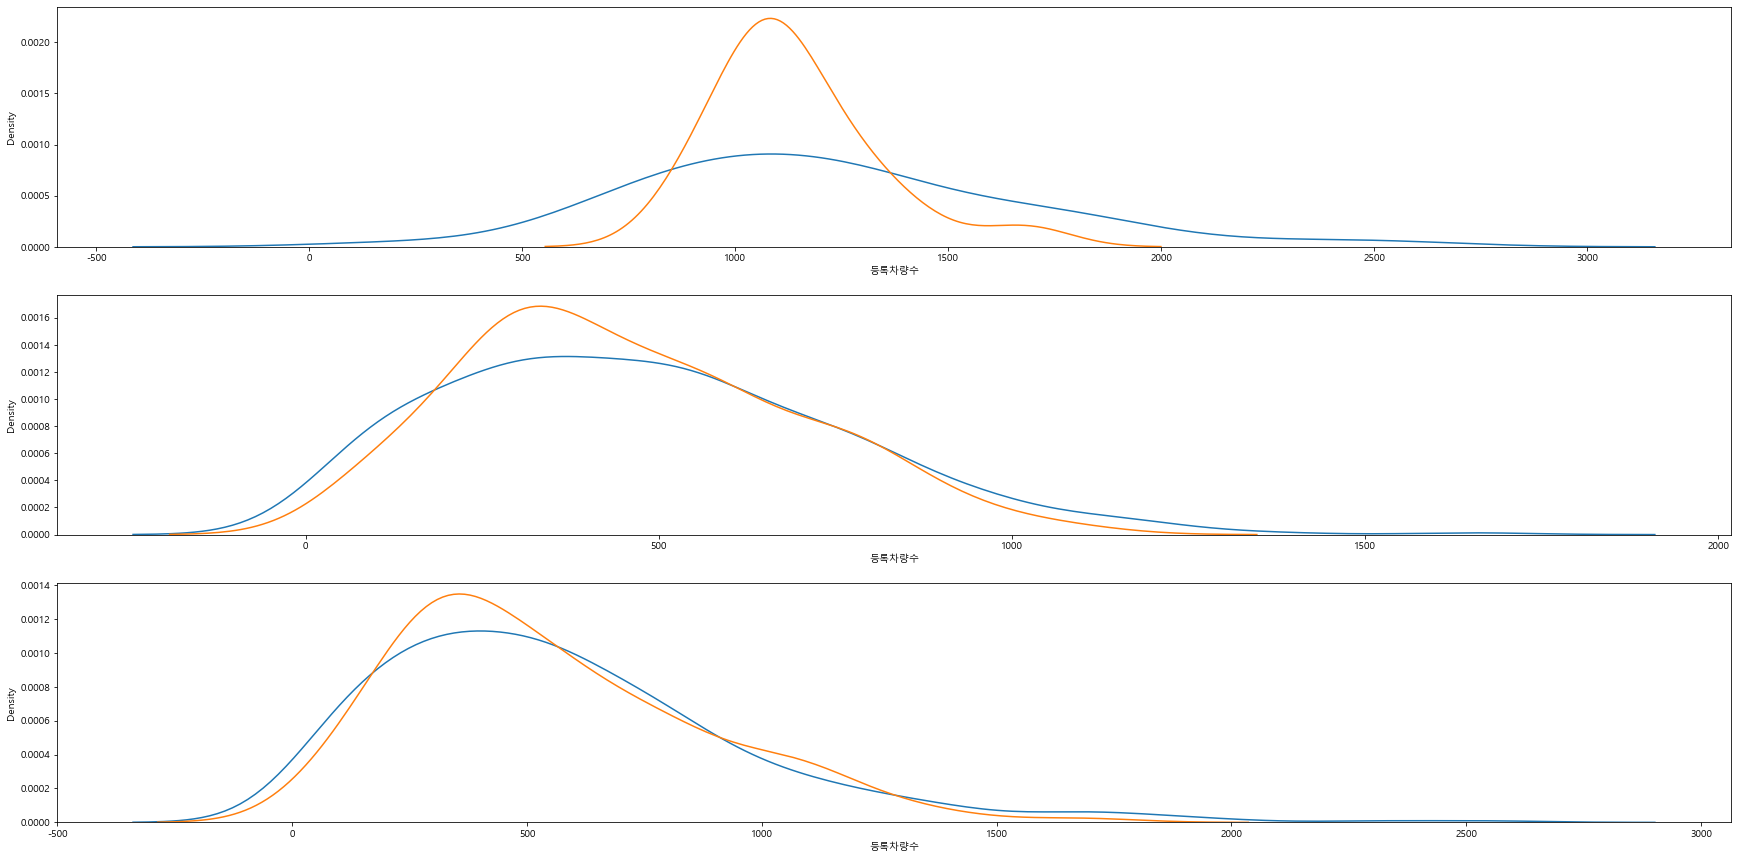

In [52]:
fig, ax = plt.subplots(3,1,figsize=(30,15))
sns.kdeplot(data=train_up,x='등록차량수',ax=ax[0])
sns.kdeplot(data=get_pred()[1],x='num',ax=ax[0])
sns.kdeplot(data=train_down,x='등록차량수',ax=ax[1])
sns.kdeplot(data=get_pred()[0],x='num',ax=ax[1])
sns.kdeplot(data=train_one,x='등록차량수',ax=ax[2])
sns.kdeplot(data=get_pred()[2],x='num',ax=ax[2])

In [53]:
def submit():
    res = get_pred()[2]
    res.loc[147,:] = ['C1327',0]
    res.loc[148,:] = ['C2335',0]
    res.loc[149,:] = ['C2675',0]
    return res

In [54]:
sub = submit()
sub.to_csv("result/result_cat_area.csv",index=False)

In [55]:
def score(mse):
    score = pd.read_csv("result/MAE_"+str(mse)+".csv")
    score = pd.merge(score,get_pred()[2],on='code',how='inner')
    score.columns = ['code','result_'+str(mse),'y_pred']
    val = test_up['단지코드'].values
    score_up = score.loc[score['code'].isin(val),:]
    score_down = score.loc[-score['code'].isin(val),:] #y가 새롭게 예측
    mae = mean_absolute_error(score['result_'+str(mse)],score['y_pred'])
    mae_up = mean_absolute_error(score_up['result_'+str(mse)],score_up['y_pred'])
    mae_down = mean_absolute_error(score_down['result_'+str(mse)],score_down['y_pred'])
    print('전체 MAE : ',mae)
    print('큰 영역 MAE : ',mae_up)
    print('작은 영역 MAE : ',mae_down)
    return score,score_up,score_down

In [65]:
res0 = score(94)

전체 MAE :  5.314173331406072
큰 영역 MAE :  41.114919985088875
작은 영역 MAE :  3.0753177782116836e-14


In [56]:
res = score(96)

전체 MAE :  5.619781037533636
큰 영역 MAE :  43.47935855354947
작은 영역 MAE :  3.68594044175552e-14


In [57]:
res1 = score(98)

전체 MAE :  8.031233248233457
큰 영역 MAE :  62.13638355212181
작은 영역 MAE :  3.0753177782116836e-14


In [58]:
res2 = score(99)

전체 MAE :  44.14536686969866
큰 영역 MAE :  121.39145789868938
작은 영역 MAE :  32.67915023258284


In [59]:
res3 = score(100)

전체 MAE :  45.89489244364459
큰 영역 MAE :  116.49517673702253
작은 영역 MAE :  35.415162743846295


In [84]:
tmp = pd.merge(test_up,res0[1],left_on='단지코드',right_on='code',how='left')
tmp = pd.merge(tmp,res1[1][['code','result_98']],left_on='단지코드',right_on='code',how='left')
tmp = pd.merge(tmp,res[1][['code','result_96']],left_on='단지코드',right_on='code',how='left')

In [85]:
tmp[tmp['지역']==0][['단지코드','총세대수','y_pred','result_94','result_96','result_98']] #작아야 함

,단지코드,총세대수,y_pred,result_94,result_96,result_98
4,C1152,1301,872.6575,866.3841,847.3162,834.6378
7,C1617,1008,"1,075.9634","1,090.6649","1,067.2961","1,050.2943"
9,C2028,1267,994.1091,"1,030.6934","1,060.4698","1,229.7132"
10,C1495,1175,"1,103.4451","1,062.9644","1,119.0351","1,016.8028"
12,C2076,1385,"1,043.5102","1,017.7006","1,023.2629","1,116.9126"


In [86]:
tmp[tmp['지역']==1][['단지코드','총세대수','y_pred','result_94','result_96','result_98']]

,단지코드,총세대수,y_pred,result_94,result_96,result_98
3,C1794,1349,"1,060.0332","1,007.0601","1,048.3720","1,001.7210"
5,C2555,1442,"1,424.2287","1,464.5241","1,440.3664","1,440.0295"
11,C1521,1414,"1,220.6401","1,173.0329","1,178.8006","1,106.6357"
13,C2473,1147,"1,091.4304","1,154.2644","1,191.6982","1,121.6203"


In [87]:
tmp[tmp['지역']==2][['단지코드','총세대수','y_pred','result_94','result_96','result_98']]

,단지코드,총세대수,y_pred,result_94,result_96,result_98
0,C1128,1354,"1,098.3990","1,149.8712","1,188.3826","1,233.5217"
1,C1332,1297,"1,277.3227","1,333.1425","1,327.9192","1,242.0480"
2,C1563,1974,"1,681.5406","1,794.8567","1,797.6878","1,748.1916"
6,C2608,1138,"1,139.3322","1,111.1436","1,193.9369","1,097.5373"
8,C1250,981,"1,222.3499","1,259.7553","1,205.9410","1,199.8978"
14,C1525,1331,"1,116.7680","1,153.1589","1,139.3794","1,241.2232"
15,C2267,1191,"1,041.3220",980.5436,940.6413,"1,001.4103"
16,C1692,1390,945.2125,974.0036,969.0050,943.7894
17,C1570,1278,910.5877,913.6061,899.0312,881.1455


In [88]:
tmp[tmp['지역']==3][['단지코드','총세대수','y_pred','result_94','result_96','result_98']]

,단지코드,총세대수,y_pred,result_94,result_96,result_98
18,C2303,963,"1,320.6850","1,282.2418","1,287.0720","1,314.2664"
